# ARIMA

Zaman serisi verisi endüstride en yaygın veri türlerinden biridir. Bu dökümanda, zaman serisi verisiyle çalışmanın temel tekniklerini ele alacağım. Bu, veri manipülasyonu, analiz ve görselleştirmeden başlayarak verinizi anlamanız ve hazırlamanız için istatistiksel, makine ve derin öğrenme tekniklerini kullanarak tahmin ve sınıflandırmaya geçiş yapmanızı sağlayacak.

Hiç geleceği tahmin etmeye çalıştınız mı? Gelecekte neler olacağı genellikle sadece bekleyerek çözülen bir gizemdir. Bu defterde ve bir sonrakinde beklemeyi bırakacak ve güçlü ARIMA sınıf modellerini kullanmayı öğreneceğiz. Statsmodels paketini kullanarak zaman serisini analiz etmeyi, özel modeller oluşturmayı ve belirsizlik altında tahmin yapmayı öğreneceksiniz. Hisse senedi piyasası önümüzdeki 24 saatte nasıl hareket edecek? CO2 seviyeleri önümüzdeki on yıl içinde nasıl değişecek? Gelecek yıl kaç deprem olacak? Tüm bu sorunları ve daha fazlasını çözmeyi öğreneceksiniz.

# 1. ARMA Modelleri
İlk olarak, ARMA modelleri için önemli olan stationarity kavramına küçük bir giriş yapacağız. Daha sonra, stationarity'yi gözle ve standart istatistiksel bir test ile nasıl kontrol edeceğimizi gözden geçireceğiz. Bu konular hakkında daha fazla bilgi almak isterseniz. Son olarak, ARMA modellerinin temel yapısını öğrenecek ve bu bilgiyi kullanarak bazı ARMA verileri oluşturacak ve bir ARMA modeli uyduracağız.

1972 ile 2018 yılları arasındaki ABD'deki aylık şekerleme üretimini temsil eden candy production veri setini kullanacağız. Özellikle, endüstriyel üretim endeksi IPG3113N'yi kullanacağız. Bu, ABD'de her ay üretilen toplam şekerleme ürünleri miktarını, Ocak 2012 üretiminin yüzdesi olarak gösterir. Bu nedenle, 120 değeri Ocak 2012 endüstriyel üretiminin %120'sini temsil eder.

Stationary (Durağan) terimi, verinin zamanla değişmediği anlamına gelir. Bir zaman serisinin durağan olması için üç kriteri yerine getirmesi gerekir:

1. Serinin sıfır trendi olmalıdır. Büyümüyor veya küçülmüyor.
2. Varyans sabit olmalıdır. Veri noktalarının sıfır çizgisinden olan ortalama mesafesi değişmemelidir.
3. Otokorelasyon sabit olmalıdır. Zaman serisindeki her bir değerin komşularına olan ilişkisi aynı kalmalıdır.
Durağanlık öneminin kaynağı, bir zaman serisini modellemek için durağan olması gerektiğidir. Bunun nedeni, modellemenin veriyi temsil eden parametreleri tahmin etmekle ilgili olmasıdır; bu nedenle, verinin parametreleri zamanla değişiyorsa, tüm parametreleri tahmin etmek zor olacaktır.

İlk olarak aylık şeker üretimi veri setini yükleyip çizelim:

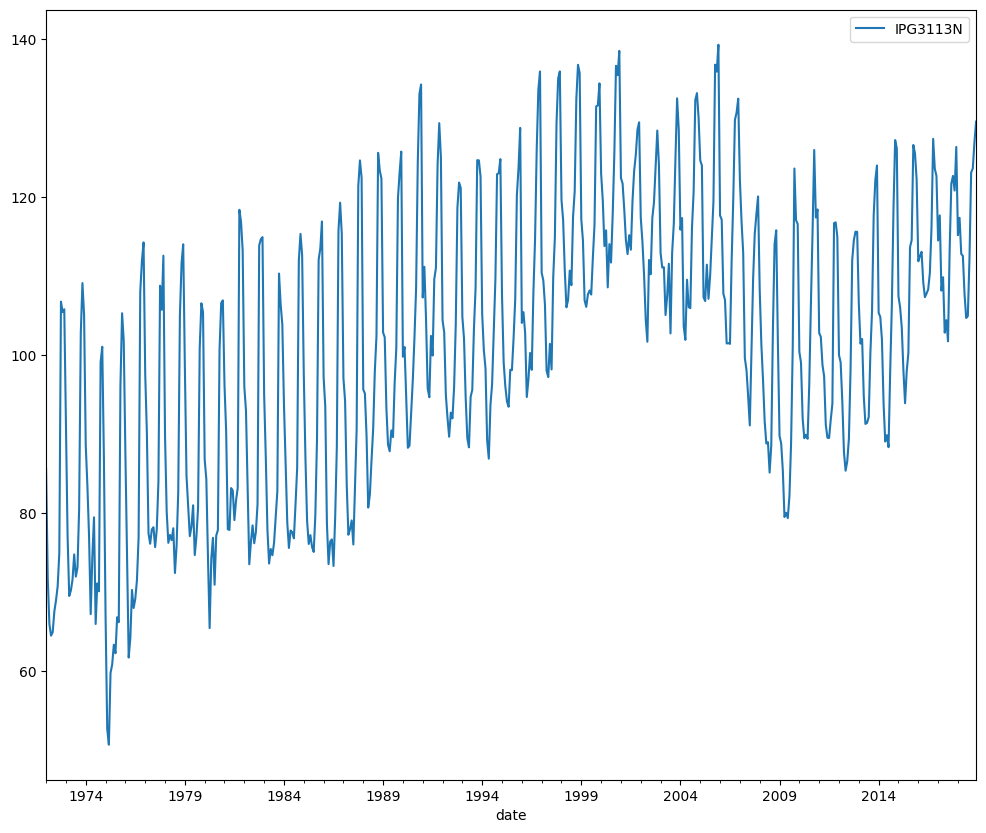

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
candy = pd.read_csv("Datasets/ARIMA/candy_production.csv",parse_dates=True,index_col="date")
fix,ax1 = plt.subplots()
candy.plot(ax=ax1,figsize=(12,10))
plt.show()

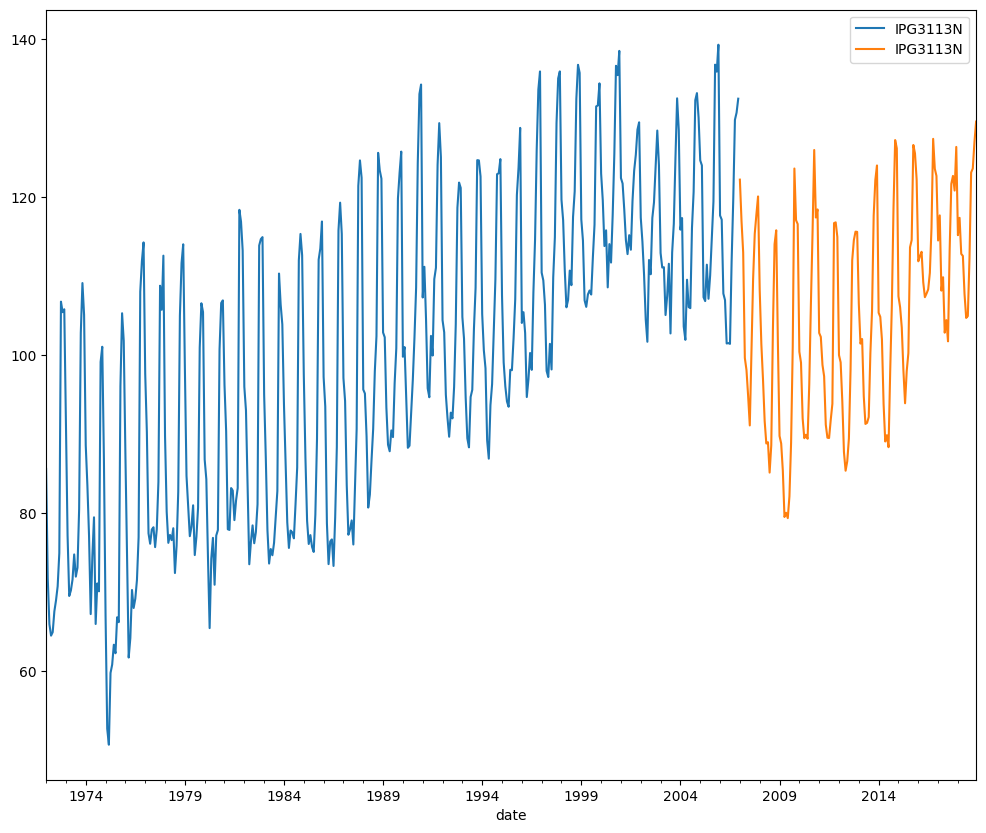

In [4]:
candy_egitim = candy.loc[:'2006']
candy_test = candy.loc['2007':]

fig,ax1 = plt.subplots()

candy_egitim.plot(ax=ax1,figsize=(12,10))
candy_test.plot(ax=ax1)
plt.show()

## Zaman Serisini Durağan Hale Getirmek
Zaman serisinin durağanlığını test etmenin birçok yolu vardır; bunlardan biri gözlemlerle yapılırken, diğerleri istatistiksel testler kullanarak daha doğru olanıdır. Ayrıca, durağan olmayan zaman serilerini durağan hale dönüştürmenin yolları da vardır. Bu alt bölümde her iki yöntemi ele alacağız ve ardından modellemeye başlamaya hazır olacaksınız.

Zaman serisinin durağan olup olmadığını belirlemede en yaygın testlerden biri, artırılmış Dickey-Fuller testidir. Bu, zaman serisinin eğilimler nedeniyle durağan olmadığını belirleyen bir istatistiksel testtir. artırılmış Dickey-Fuller testini uygulayabiliriz. İlk olarak, gösterildiği gibi statsmodels kütüphanesinden adfuller fonksiyonunu içe aktarıyoruz, ardından bu fonksiyonu şeker üretimi zaman serisi üzerinde çalıştırabiliriz


In [5]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(candy)
print(results)

(-1.7760153075016134, 0.3924327500713988, 14, 549, {'1%': -3.4423174665535385, '5%': -2.866818952732754, '10%': -2.569581505602171}, 3094.828881317046)


In [6]:
candy_diff = candy.diff()
candy_diff = candy_diff.dropna()

results = adfuller(candy_diff)
print(results)

(-6.175912489755701, 6.631549159334048e-08, 13, 549, {'1%': -3.4423174665535385, '5%': -2.866818952732754, '10%': -2.569581505602171}, 3091.3123583091397)


AR(p)<br> 
y(t) = a(1) * y(t-1) + ϵ(t)<br> 
MA(q)<br>
y(t) = m(1)*ϵ(t-1) + ϵ(t)<br> 
ARMA(p,q)<br>
y(t) = a (1)y(t-1) + m(1) ϵ(t-1) + ϵ(t)<br> 


In [9]:
from statsmodels.tsa.arima_process import arma_generate_sample
ar_coefs = [1,-0.5]
ma_coefs = [1,0.2]
y= arma_generate_sample(ar_coefs,ma_coefs,nsample=100,scale=0.5)

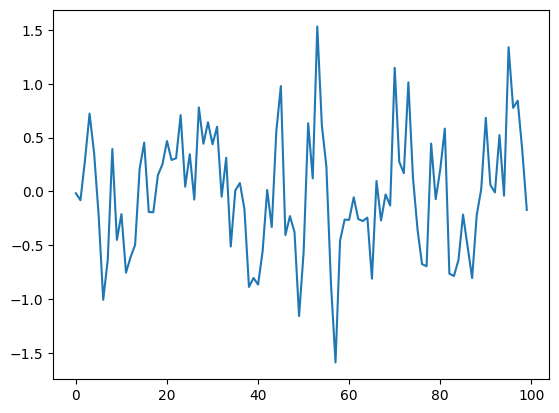

In [10]:
fig,ax = plt.subplots()
ax.plot(y)

In [12]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y,order=(1,0,1))
sonuclar = model.fit(y)

ARIMA(p,d,q)
* p => otoregresif gecikmeleri AR 
* d => fark düzeyi
* q => hareketli ortalama gecikmeleri MA 

In [14]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y,order=(1,0,1))
sonuclar = model.fit()
print(sonuclar.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -73.570
Date:                Mon, 11 Dec 2023   AIC                            155.141
Time:                        10:40:17   BIC                            165.562
Sample:                             0   HQIC                           159.358
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0166      0.098     -0.170      0.865      -0.208       0.175
ar.L1          0.4693      0.224      2.094      0.036       0.030       0.908
ma.L1         -0.0339      0.254     -0.134      0.8

* ARMA <br>
y(t) = a(1) y(t-1) + m(1) ϵ(t-1) + ϵ(t)<br>
* ARMAX <br>
y = x(1)* z(t) + a(1) y(t-1) + m (1)ϵ(t-1) + ϵ(t)

In [16]:
from numpy import cumsum
ortalama_tahmin = cumsum(candy_diff) + candy.iloc[-1,0]
ortalama_tahmin

,IPG3113N
date,
1972-02-01,115.713668
1972-03-01,109.921074
1972-04-01,108.462988
1972-05-01,108.906106
1972-06-01,111.536652
...,...
2018-08-01,156.252041
2018-09-01,167.098600
2018-10-01,167.606533


y = 0.5 x 15 + ϵ(t)

Non Stationary Zaman Serileri için ARIMA Modelleri

<Axes: xlabel='date'>

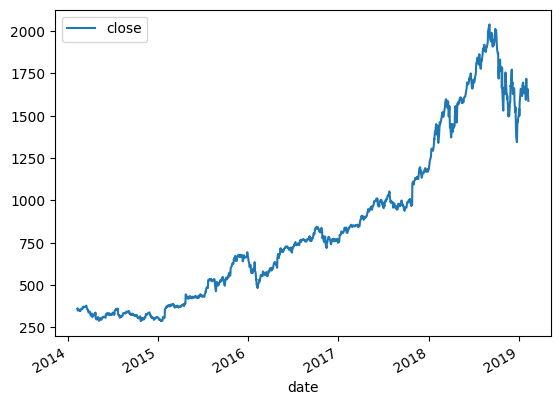

In [17]:
amazon = pd.read_csv("Datasets/ARIMA/amazon_close.csv",index_col="date",parse_dates=True)
amazon.plot()

In [18]:
from statsmodels.tsa.stattools import adfuller

sonuc = adfuller(amazon)
print(sonuc)

(-1.3446690965326025, 0.6084966311408393, 23, 1235, {'1%': -3.4356560275160835, '5%': -2.8638831211270817, '10%': -2.568017509711682}, 10782.877783880944)


In [20]:
amazon_diff = amazon.diff()
amazon_diff.dropna(inplace=True)
sonuclar = adfuller(amazon_diff)
sonuclar

(-7.2035794888112505,
 2.331271725487086e-10,
 23,
 1234,
 {'1%': -3.435660336370594,
  '5%': -2.863885022214541,
  '10%': -2.568018522153254},
 10764.626718933836)

In [21]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(amazon_diff, order=(1,0,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1258
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5536.175
Date:                Mon, 11 Dec 2023   AIC                          11080.350
Time:                        10:52:12   BIC                          11100.900
Sample:                             0   HQIC                         11088.073
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9877      0.457     -2.160      0.031      -1.884      -0.092
ar.L1          0.8267      0.078     10.556      0.000       0.673       0.980
ma.L1         -0.8603      0.072    -11.866      0.0

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(amazon,order=(1,1,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5538.450
Date:                Mon, 11 Dec 2023   AIC                          11082.901
Time:                        10:54:00   BIC                          11098.312
Sample:                             0   HQIC                         11088.693
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8065      0.104      7.726      0.000       0.602       1.011
ma.L1         -0.8352      0.099     -8.450      0.000      -1.029      -0.641
sigma2       390.4373      5.974     65.352      0.0

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ACF ve PACF kullanımı

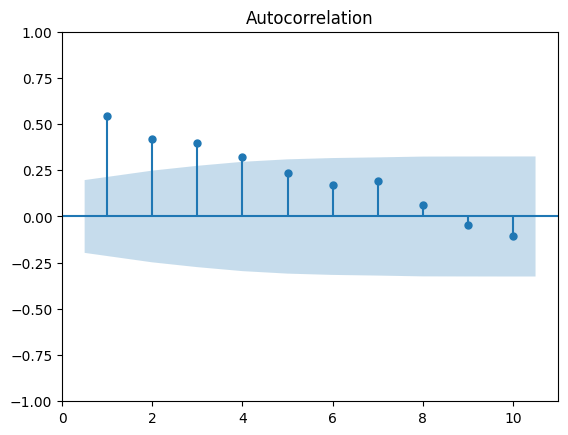

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
deprem = pd.read_csv("Datasets/ARIMA/earthquakes.csv")
plot_acf(deprem["earthquakes_per_year"],lags=10,zero=False)
plt.show()

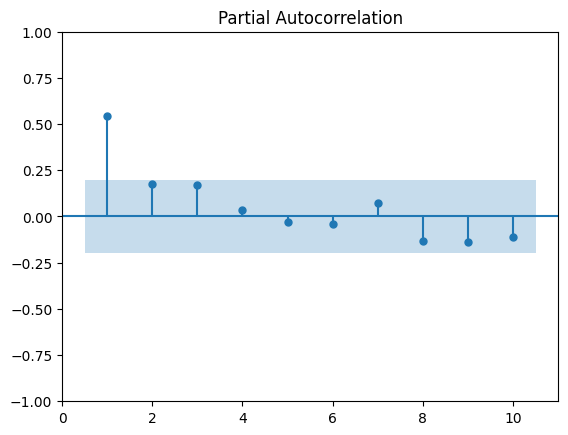

In [28]:
plot_pacf(deprem["earthquakes_per_year"],lags=10,zero=False)
plt.show()

AIC ve BIC kullanımı

In [34]:
import statsmodels.api as sm
order_aic_bic = []

for p in range(3):
    for q in range(3):
        try:
            model = sm.tsa.statespace.SARIMAX(deprem["earthquakes_per_year"],order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p,q,results.aic,results.bic))
        except:
            print(p,q,None,None)
order_df = pd.DataFrame(order_aic_bic,columns=["p","q","aic","bic"])

print("AIC Sıralı")
print(order_df.sort_values('aic').reset_index(drop=True))
print("BIC Sıralı")
print(order_df.sort_values('bic').reset_index(drop=True))


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47692D+00    |proj g|=  2.21156D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.212D-08   4.477D+00
  F =   4.4769180418808485     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.2

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.22652D+00    |proj g|=  1.97595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   1.053D-05   3.227D+00
  F =   3.2265184057744687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
AIC Sıralı
   p  q         aic         bic
0  1  1  647.132300  654.917660
1  1  2  648.738566  659.119046
2  2  1  648.842840  659.223319
3  2  2  648.850644  661.826244
4  2  0  656.028374  663.813734
5  1  0  666.645526  671.835765
6  0  2  761.067479  768.852838
7  0  1  799.674173  804.864412
8  0  0  888.429772  891.024892
BIC Sıralı
   p  q         aic

Model Bilgilerini almak

In [35]:
model = sm.tsa.statespace.SARIMAX(deprem["earthquakes_per_year"],order=(1,0,1))
results = model.fit()
hatalar = results.resid
print(hatalar)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24438D+00    |proj g|=  6.79014D-02

At iterate    5    f=  3.23891D+00    |proj g|=  7.28400D-04

At iterate   10    f=  3.23870D+00    |proj g|=  1.18872D-02

At iterate   15    f=  3.23804D+00    |proj g|=  3.81184D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   8.732D-07   3.238D+00
  F =   3.2380419190271801     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0     13

 This problem is unconstrained.


In [36]:
import numpy as np
mae = np.mean(np.abs(hatalar))
print(mae)

4.755625669941166


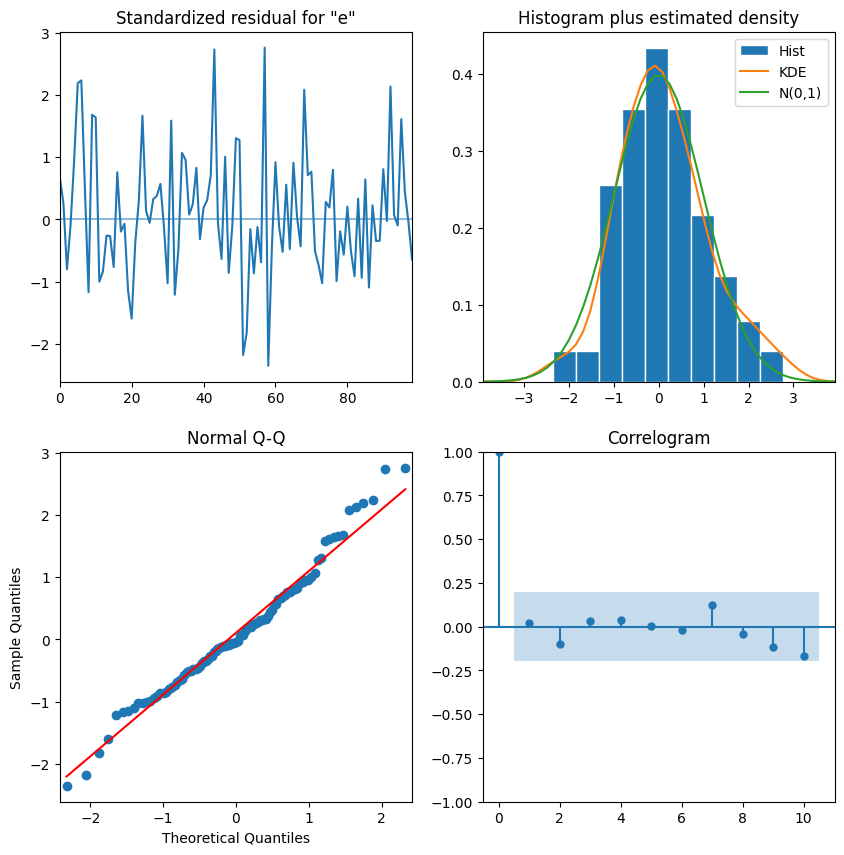

In [38]:
results.plot_diagnostics(figsize=(10,10))
plt.show()

In [40]:
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:     earthquakes_per_year   No. Observations:                   99
Model:                 SARIMAX(1, 0, 1)   Log Likelihood                -320.566
Date:                  Mon, 11 Dec 2023   AIC                            647.132
Time:                          11:34:52   BIC                            654.918
Sample:                               0   HQIC                           650.282
                                   - 99                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9893      0.014     70.282      0.000       0.962       1.017
ma.L1         -0.5517      0.089     -6.198      0.000      -0.726      -0.377
sigma2        37.0254      4.980    

<Axes: xlabel='date'>

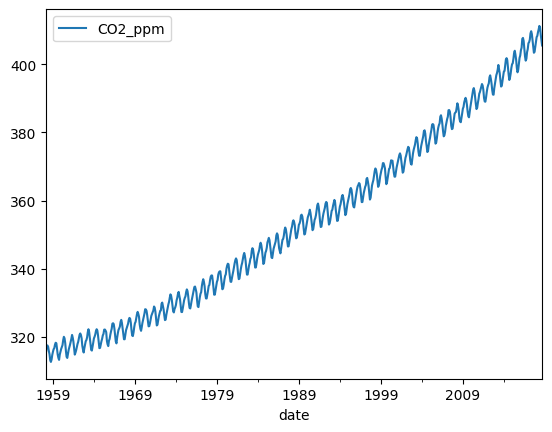

In [41]:
co2 = pd.read_csv("Datasets/ARIMA/co2.csv",index_col="date",parse_dates=True)
co2.plot()

In [43]:
from statsmodels.tsa.stattools import adfuller

sonuc = adfuller(co2)
sonuc

(4.774866785205426,
 1.0,
 20,
 706,
 {'1%': -3.439646367660705,
  '5%': -2.8656425177031375,
  '10%': -2.5689546724554404},
 494.90714335429107)

<Axes: xlabel='date'>

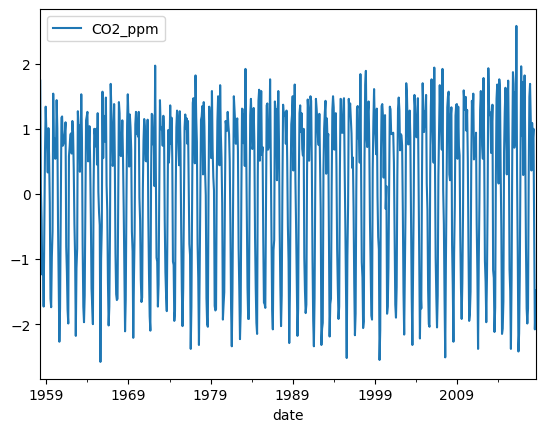

In [44]:
co2_diff = co2.diff()
co2_diff = co2_diff.dropna()
co2_diff.plot()

In [45]:
sonuc_diff = adfuller(co2_diff)
sonuc_diff

(-5.287425631615292,
 5.813789175331712e-06,
 20,
 705,
 {'1%': -3.4396596024765795,
  '5%': -2.86564834926679,
  '10%': -2.568957779286756},
 504.3526488821651)

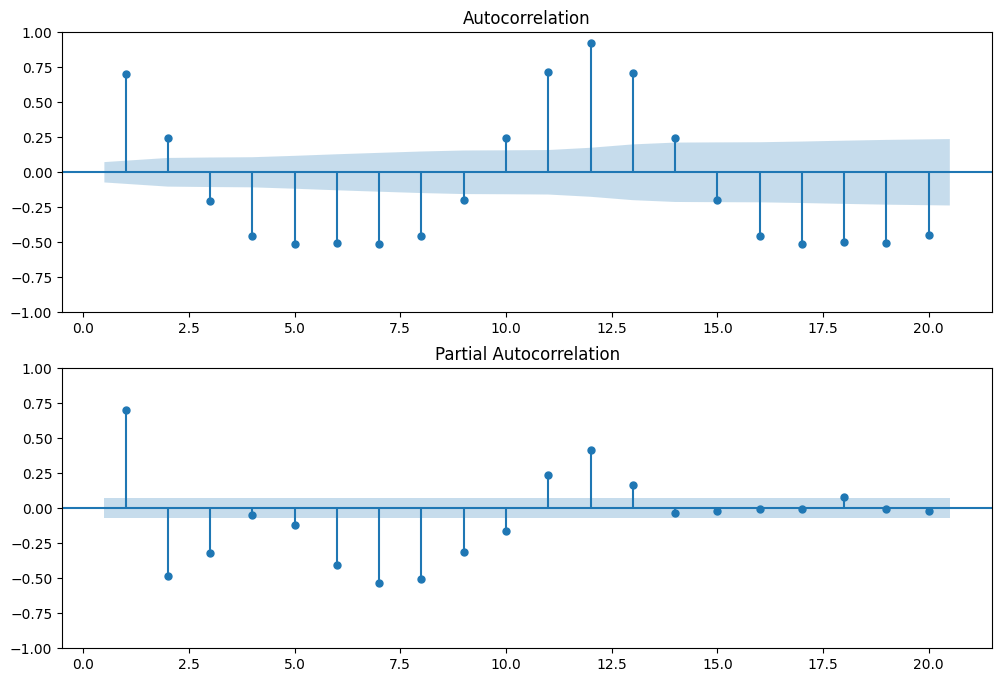

In [46]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
plot_acf(co2_diff,lags=20,zero=False,ax=ax1)
plot_pacf(co2_diff,lags=20,zero=False,ax=ax2)
plt.show()

In [48]:
import statsmodels.api as sm
order_aic_bic = []

for p in range(5):
    for q in range(5):
        try:
            model = sm.tsa.statespace.SARIMAX(co2,order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p,q,results.aic,results.bic))
        except:
            print(p,q,None,None)
order_df = pd.DataFrame(order_aic_bic,columns=["p","q","aic","bic"])

print("AIC Sıralı")
print(order_df.sort_values('aic').reset_index(drop=True))
print("BIC Sıralı")
print(order_df.sort_values('bic').reset_index(drop=True))

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29022D+00    |proj g|=  8.88178D-11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.882D-11   7.290D+00
  F =   7.2902178319530035     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.2

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29022D+00    |proj g|=  9.96315D-01

At iterate    5    f=  6.83639D+00    |proj g|=  6.25637D-03

At iterate   10    f=  6.06279D+00    |proj g|=  2.09575D-03

At iterate   15    f=  5.92997D+00    |proj g|=  3.03437D-03

At iterate   20    f=  5.92409D+00    |proj g|=  1.11638D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     44      1     0     0   2.490D-07   5.924D+00
  F =   5.9240832852548451     

CONVERG

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  6.81048D+00    |proj g|=  3.20654D-03

At iterate   10    f=  6.63653D+00    |proj g|=  3.28082D-03

At iterate   15    f=  6.11165D+00    |proj g|=  1.04077D+00

At iterate   20    f=  5.37979D+00    |proj g|=  1.20672D-01

At iterate   25    f=  5.30029D+00    |proj g|=  1.17563D-02

At iterate   30    f=  5.29560D+00    |proj g|=  2.07453D-02

At iterate   35    f=  5.29487D+00    |proj g|=  6.66487D-04

At iterate   40    f=  5.29480D+00    |proj g|=  2.74333D-04

At iterate   45    f=  5.29479D+00    |proj g|=  2.99076D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     80   

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29022D+00    |proj g|=  9.93988D-01

At iterate    5    f=  6.80344D+00    |proj g|=  2.77319D-03

At iterate   10    f=  6.74904D+00    |proj g|=  6.51873D-03

At iterate   15    f=  6.40786D+00    |proj g|=  1.92389D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     52      1     0     0   3.866D-01   5.773D+00
  F =   5.7729554525823392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autore

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17168D+04    |proj g|=  8.33108D+04

At iterate    5    f=  3.25010D+02    |proj g|=  6.33471D+02

At iterate   10    f=  2.17937D+01    |proj g|=  2.36443D+01

At iterate   15    f=  3.75777D+00    |proj g|=  9.44821D-01

At iterate   20    f=  1.88294D+00    |proj g|=  7.48856D-02

At iterate   25    f=  1.69341D+00    |proj g|=  3.62495D-02

At iterate   30    f=  1.64369D+00    |proj g|=  5.14446D-03

At iterate   35    f=  1.63749D+00    |proj g|=  2.76120D-03

At iterate   40    f=  1.63719D+00    |proj g|=  7.84686D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11716D+04    |proj g|=  2.31240D+04

At iterate    5    f=  7.00833D+01    |proj g|=  1.44185D+02

At iterate   10    f=  5.96064D+00    |proj g|=  5.35434D+00

At iterate   15    f=  2.44374D+00    |proj g|=  2.39902D-01

At iterate   20    f=  1.66306D+00    |proj g|=  2.22784D-01

At iterate   25    f=  1.28928D+00    |proj g|=  2.28337D-01

At iterate   30    f=  1.22408D+00    |proj g|=  4.25268D-02

At iterate   35    f=  1.21461D+00    |proj g|=  5.17392D-03

At iterate   40    f=  1.21374D+00    |proj g|=  1.31047D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32040D+04    |proj g|=  3.00702D+04

At iterate    5    f=  4.36029D+01    |proj g|=  9.28834D+01

At iterate   10    f=  4.32322D+00    |proj g|=  3.42763D+00

At iterate   15    f=  2.21416D+00    |proj g|=  1.59634D-01

At iterate   20    f=  1.45295D+00    |proj g|=  6.34772D-02

At iterate   25    f=  1.20412D+00    |proj g|=  1.26183D-01

At iterate   30    f=  1.15654D+00    |proj g|=  1.75028D-02

At iterate   35    f=  1.14690D+00    |proj g|=  5.22544D-02

At iterate   40    f=  1.14540D+00    |proj g|=  3.11374D-03

At iterate   45    f=  1.14535D+00    |proj g|=  4.07010D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15104D+04    |proj g|=  1.02870D+05

At iterate    5    f=  8.41701D+01    |proj g|=  2.02464D+02

At iterate   10    f=  5.95723D+00    |proj g|=  7.34849D+00

At iterate   15    f=  2.28430D+00    |proj g|=  3.24515D-01

At iterate   20    f=  1.53459D+00    |proj g|=  2.58677D-01

At iterate   25    f=  1.20998D+00    |proj g|=  1.02932D-01

At iterate   30    f=  1.15462D+00    |proj g|=  2.14094D-02

At iterate   35    f=  1.14484D+00    |proj g|=  3.98541D-03

At iterate   40    f=  1.14406D+00    |proj g|=  4.81243D-03

At iterate   45    f=  1.14403D+00    |proj g|=  1.96872D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24485D+04    |proj g|=  1.88773D+05

At iterate    5    f=  2.08551D+02    |proj g|=  4.91697D+02

At iterate   10    f=  1.18866D+01    |proj g|=  1.71013D+01

At iterate   15    f=  2.81565D+00    |proj g|=  6.35086D-01

At iterate   20    f=  2.29464D+00    |proj g|=  3.11556D-02

At iterate   25    f=  2.25034D+00    |proj g|=  2.59410D-03

At iterate   30    f=  1.38450D+00    |proj g|=  3.43211D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77908D+04    |proj g|=  9.89983D+04

At iterate    5    f=  7.25268D+01    |proj g|=  1.68757D+02

At iterate   10    f=  5.12267D+00    |proj g|=  5.85334D+00

At iterate   15    f=  2.08806D+00    |proj g|=  2.33829D-01

At iterate   20    f=  1.71585D+00    |proj g|=  3.43588D-02

At iterate   25    f=  1.64017D+00    |proj g|=  4.15066D-03

At iterate   30    f=  1.62064D+00    |proj g|=  5.23448D-02

At iterate   35    f=  1.61248D+00    |proj g|=  9.27905D-04

At iterate   40    f=  1.61213D+00    |proj g|=  1.44589D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  4.68262D+00    |proj g|=  5.74808D+00

At iterate   15    f=  1.86467D+00    |proj g|=  2.19089D-01

At iterate   20    f=  1.40426D+00    |proj g|=  5.49697D-02

At iterate   25    f=  1.34276D+00    |proj g|=  7.86636D-03

At iterate   30    f=  1.33851D+00    |proj g|=  4.42234D-04

At iterate   35    f=  1.33821D+00    |proj g|=  3.95832D-03

At iterate   40    f=  1.33687D+00    |proj g|=  3.86036D-03

At iterate   45    f=  1.33568D+00    |proj g|=  4.04747D-03


/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet


At iterate   50    f=  1.33561D+00    |proj g|=  1.60223D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   1.602D-03   1.336D+00
  F =   1.3356098846123670     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17083D+05    |proj g|=  3.19454D+05

At iterate    5    f=  1.04496D+02    |proj g|=  2.61743D+02

At iterate   10    f=  5.79548D+00    |proj g|=  8.93220D+00

At iter

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


At iterate   50    f=  1.21133D+00    |proj g|=  8.96964D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   8.970D-03   1.211D+00
  F =   1.2113317259685357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21933D+05    |proj g|=  8.33682D+05

At iterate    5    f=  1.27962D+02    |proj g|=  3.25399D+02

At iterate   10    f=  6.45054D+00    |proj g|=  1.11132D+01

At iterate   15    f=  1.80111D+00    |proj g|=  4.03804D-01

At iterate   20    f=  1.26591D+00    |proj g|=  1.24352D-01

At iterate   25    f=  1.16220D+00    |proj g|=  5.09175D-02

At iterate   30    f=  1.14705D+00    |proj g|=  1.37870D-02

At iterate   35    f=  1.14598D+00    |proj g|=  2.78705D-03

At iterate   40    f=  1.14596D+00    |proj g|=  3.37567D-03

At iterate   45    f=  1.14540D+00    |proj g|=  1.92809D-02


/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet


At iterate   50    f=  1.14456D+00    |proj g|=  1.39751D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.398D-03   1.145D+00
  F =   1.1445558826038120     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08055D+05    |proj g|=  2.83226D+05

At iterate    5    f=  1.19057D+02    |proj g|=  2.80578D+02

At iterate   10    f=  8.65488D+00    |proj g|=  9.72758D+00

At iter

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet


At iterate   50    f=  1.16144D+00    |proj g|=  7.20530D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     74      1     1     0   7.205D-06   1.161D+00
  F =   1.1614449397827078     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91478D+04    |proj g|=  7.63559D+04

At iterate    5    f=  3.31874D+01    |proj g|=  7.56564D+01

At iterate   10    f=  3.52921D+00    |proj g|=  2.65509D+00

At iter

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24127D+05    |proj g|=  8.90165D+05

At iterate    5    f=  1.70030D+02    |proj g|=  4.24033D+02

At iterate   10    f=  8.70320D+00    |proj g|=  1.43182D+01

At iterate   15    f=  2.24058D+00    |proj g|=  5.64796D-01

At iterate   20    f=  1.67062D+00    |proj g|=  1.09826D-01

At iterate   25    f=  1.58305D+00    |proj g|=  2.83687D-02

At iterate   30    f=  1.49321D+00    |proj g|=  1.93737D-01

At iterate   35    f=  1.29479D+00    |proj g|=  4.82596D-02

At iterate   40    f=  1.24386D+00    |proj g|=  2.14182D-02

At iterate   45    f=  1.23051D+00    |proj g|=  4.13690D-02

At iterate   50    f=  1.22914D+00    |proj g|=  2.81563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47945D+05    |proj g|=  4.53751D+05

At iterate    5    f=  7.45739D+01    |proj g|=  1.84744D+02

At iterate   10    f=  4.53602D+00    |proj g|=  6.22178D+00

At iterate   15    f=  1.76974D+00    |proj g|=  2.29301D-01

At iterate   20    f=  1.38510D+00    |proj g|=  1.14509D-01

At iterate   25    f=  1.32129D+00    |proj g|=  1.57195D-02

At iterate   30    f=  1.31713D+00    |proj g|=  1.93395D-02

At iterate   35    f=  1.22116D+00    |proj g|=  3.39797D-01

At iterate   40    f=  1.18217D+00    |proj g|=  2.52343D-02

At iterate   45    f=  1.18092D+00    |proj g|=  5.32347D-03

At iterate   50    f=  1.17999D+00    |proj g|=  2.10326D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01231D+05    |proj g|=  1.31830D+06

At iterate    5    f=  8.81232D+01    |proj g|=  2.20162D+02

At iterate   10    f=  4.80325D+00    |proj g|=  7.37544D+00

At iterate   15    f=  1.64762D+00    |proj g|=  2.37525D-01

At iterate   20    f=  1.29508D+00    |proj g|=  9.84278D-02

At iterate   25    f=  1.22738D+00    |proj g|=  1.02107D-01

At iterate   30    f=  1.21646D+00    |proj g|=  1.90862D-02

At iterate   35    f=  1.21314D+00    |proj g|=  2.24980D-02

At iterate   40    f=  1.21008D+00    |proj g|=  5.43712D-03

At iterate   45    f=  1.20974D+00    |proj g|=  5.48706D-03

At iterate   50    f=  1.20924D+00    |proj g|=  1.08186D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19969D+05    |proj g|=  3.31336D+05

At iterate    5    f=  8.64902D+01    |proj g|=  1.93077D+02

At iterate   10    f=  9.42958D+00    |proj g|=  8.48204D+00

At iterate   15    f=  3.34252D+00    |proj g|=  3.90810D-01

At iterate   20    f=  1.98880D+00    |proj g|=  3.71417D-01

At iterate   25    f=  1.36217D+00    |proj g|=  1.11454D-01

At iterate   30    f=  1.30116D+00    |proj g|=  1.77196D-02

At iterate   35    f=  1.27623D+00    |proj g|=  1.38511D-02

At iterate   40    f=  1.27480D+00    |proj g|=  4.36589D-03

At iterate   45    f=  1.27478D+00    |proj g|=  5.96607D-04


/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet


At iterate   50    f=  1.27478D+00    |proj g|=  6.08740D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   6.087D-04   1.275D+00
  F =   1.2747801701292885     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.35114D+04    |proj g|=  1.20111D+05

At iterate    5    f=  3.15747D+01    |proj g|=  6.86861D+01

At iterate   10    f=  4.34074D+00    |proj g|=  2.74487D+00

At iter

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28453D+05    |proj g|=  3.57839D+05

At iterate    5    f=  5.42819D+01    |proj g|=  1.27433D+02

At iterate   10    f=  4.63175D+00    |proj g|=  4.53917D+00

At iterate   15    f=  2.17681D+00    |proj g|=  2.06060D-01

At iterate   20    f=  1.37121D+00    |proj g|=  2.52782D-01

At iterate   25    f=  1.31485D+00    |proj g|=  4.47573D-02

At iterate   30    f=  1.28912D+00    |proj g|=  4.66105D-03

At iterate   35    f=  1.28837D+00    |proj g|=  1.16560D-03

At iterate   40    f=  1.28787D+00    |proj g|=  3.84133D-02

At iterate   45    f=  1.28041D+00    |proj g|=  9.66639D-02

At iterate   50    f=  1.12029D+00    |proj g|=  1.50143D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48964D+05    |proj g|=  4.58445D+05

At iterate    5    f=  4.20392D+01    |proj g|=  9.90075D+01

At iterate   10    f=  3.64158D+00    |proj g|=  3.45846D+00

At iterate   15    f=  1.76524D+00    |proj g|=  1.46320D-01

At iterate   20    f=  1.45525D+00    |proj g|=  1.21446D-01

At iterate   25    f=  1.28469D+00    |proj g|=  1.76326D-01

At iterate   30    f=  1.24669D+00    |proj g|=  3.47892D-02

At iterate   35    f=  1.22511D+00    |proj g|=  6.33655D-03

At iterate   40    f=  1.22323D+00    |proj g|=  2.99363D-02

At iterate   45    f=  1.21987D+00    |proj g|=  2.86302D-02

At iterate   50    f=  1.21756D+00    |proj g|=  4.83478D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02149D+05    |proj g|=  1.32434D+06

At iterate    5    f=  6.16212D+01    |proj g|=  1.49040D+02

At iterate   10    f=  4.10593D+00    |proj g|=  5.10829D+00

At iterate   15    f=  1.62140D+00    |proj g|=  2.19400D-01

At iterate   20    f=  1.35025D+00    |proj g|=  5.77775D-02

At iterate   25    f=  1.27018D+00    |proj g|=  1.72827D-01

At iterate   30    f=  1.19849D+00    |proj g|=  1.51471D-01

At iterate   35    f=  1.14467D+00    |proj g|=  1.27747D-01

At iterate   40    f=  1.10916D+00    |proj g|=  4.37606D-02

At iterate   45    f=  1.10718D+00    |proj g|=  7.69982D-03

At iterate   50    f=  1.10481D+00    |proj g|=  3.03464D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['trenc']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressiv

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87262D+00    |proj g|=  7.56699D+00

At iterate    5    f=  1.05284D+00    |proj g|=  5.34243D-02

At iterate   10    f=  1.03704D+00    |proj g|=  1.07712D-02

At iterate   15    f=  1.03215D+00    |proj g|=  8.69923D-03

At iterate   20    f=  1.02745D+00    |proj g|=  5.41561D-02

At iterate   25    f=  1.01496D+00    |proj g|=  3.47504D-02

At iterate   30    f=  9.51145D-01    |proj g|=  2.41222D-01

At iterate   35    f=  8.96544D-01    |proj g|=  1.83539D-01

At iterate   40    f=  8.73911D-01    |proj g|=  1.70672D-01

At iterate   45    f=  8.40531D-01    |proj g|=  8.06774D-02

At iterate   50    f=  8.10533D-01    |proj g|=  1.80434D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


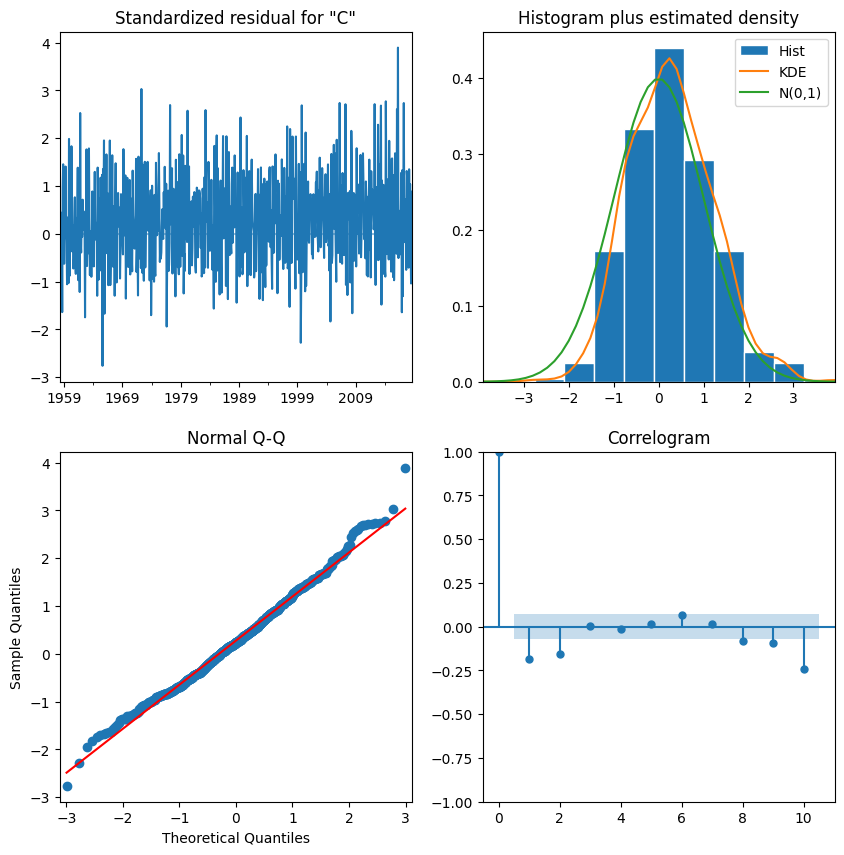

                               SARIMAX Results                                
Dep. Variable:                CO2_ppm   No. Observations:                  727
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -589.257
Date:                Mon, 11 Dec 2023   AIC                           1196.515
Time:                        11:49:22   BIC                           1237.803
Sample:                    03-01-1958   HQIC                          1212.448
                         - 09-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4291      0.076     32.040      0.000       2.280       2.578
ar.L2         -2.8385      0.179    -15.857      0.000      -3.189      -2.488
ar.L3          1.8009      0.169     10.678      0.0

In [50]:
model = sm.tsa.statespace.SARIMAX(co2,order=(4,1,4),trenc="c")
results = model.fit()
results.plot_diagnostics(figsize=(10,10))
plt.show()
print(results.summary())

# SARIMA

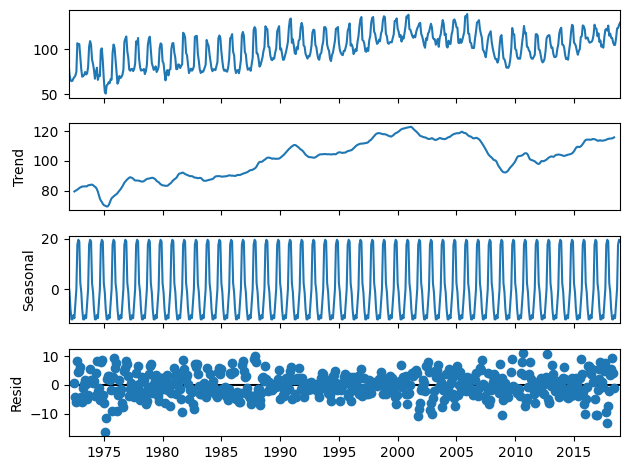

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

candy = pd.read_csv("Datasets/ARIMA/candy_production.csv",index_col="date",parse_dates=True)

ayrik_sonuclar = seasonal_decompose(candy,period=12)
ayrik_sonuclar.plot()
plt.show()

In [52]:
candy = candy - candy.rolling(5).mean()

In [53]:
candy = candy.dropna()

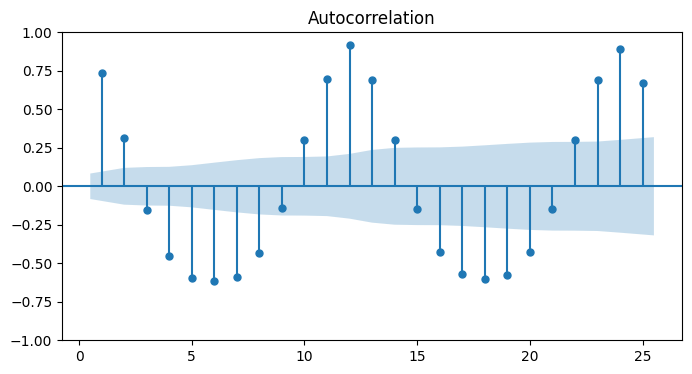

In [54]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
plot_acf(candy,ax=ax,lags=25,zero=False)
plt.show()

* ARIMA (2,0,1)<br>
y(t) = a(1) y(t-1) + a(2) y(t-2) + m(1) ϵ(t-1) + ϵ(t)<br>
* SARIMA(0,0,0)(2,0,1)7<br>
y = a (7)y(t-7) + a(14)y(t-14) + m(7) ϵ(t-7) + ϵ(t)
```
import statsmodels.api as sm

model = sm(df, order=(p,d,q), seasonal_order=(P,D,Q,S))
```

<Axes: xlabel='date'>

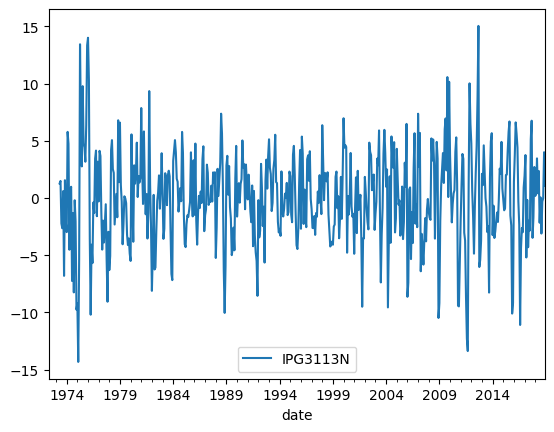

In [55]:
S = 12 
candy_diff = candy.diff(S)
candy_diff.plot()

<Axes: xlabel='date'>

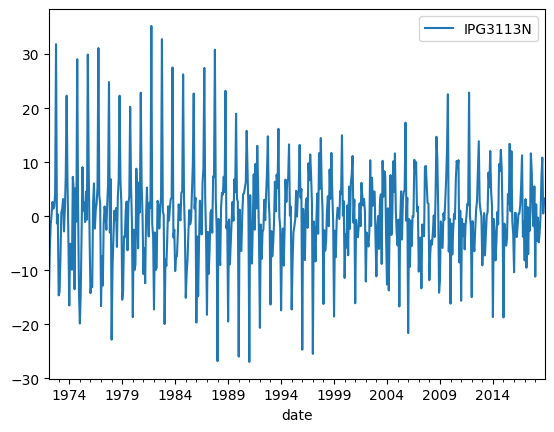

In [60]:
candy = pd.read_csv("Datasets/ARIMA/candy_production.csv",index_col="date",parse_dates=True)
candy_diff = candy.diff()
candy_diff = candy_diff.dropna()
candy_diff.plot()

In [61]:
sonuc = adfuller(candy_diff)
sonuc 

(-6.175912489755701,
 6.631549159334048e-08,
 13,
 549,
 {'1%': -3.4423174665535385,
  '5%': -2.866818952732754,
  '10%': -2.569581505602171},
 3091.3123583091397)

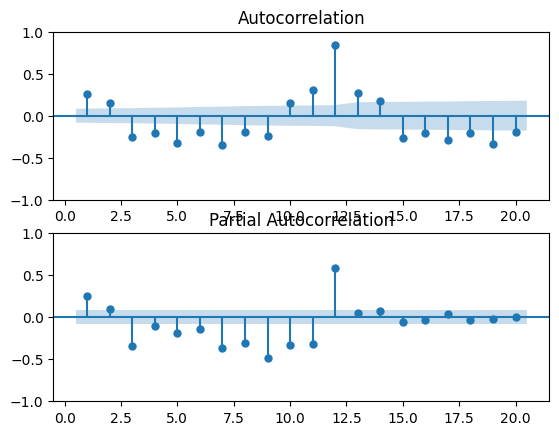

In [62]:
fig,(ax1,ax2) = plt.subplots(2,1)
plot_acf(candy_diff,lags=20,zero=False,ax=ax1)
plot_pacf(candy_diff,lags=20,zero=False,ax=ax2)
plt.show()

In [63]:
import statsmodels.api as sm
order_aic_bic = []

for p in range(5):
    for q in range(5):
        try:
            model = sm.tsa.statespace.SARIMAX(candy_diff,order=(p,1,q))
            results = model.fit()
            order_aic_bic.append((p,q,results.aic,results.bic))
        except:
            print(p,q,None,None)
order_df = pd.DataFrame(order_aic_bic,columns=["p","q","aic","bic"])

print("AIC Sıralı")
print(order_df.sort_values('aic').reset_index(drop=True))
print("BIC Sıralı")
print(order_df.sort_values('bic').reset_index(drop=True))

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.79880D+00    |proj g|=  1.63365D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   2.469D-06   3.799D+00
  F =   3.7987942296421027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.6

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.55075D+00    |proj g|=  1.86472D-02

At iterate   10    f=  3.54146D+00    |proj g|=  4.72631D-03

At iterate   15    f=  3.53929D+00    |proj g|=  9.20674D-04

At iterate   20    f=  3.53904D+00    |proj g|=  9.44151D-04

At iterate   25    f=  3.53901D+00    |proj g|=  3.58948D-04

At iterate   30    f=  3.53900D+00    |proj g|=  1.23356D-04

At iterate   35    f=  3.53900D+00    |proj g|=  4.82568D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     42      1     0     0   4.826D-05   3.539D+00
  F =   3.5390032417451063     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  3.53569D+00    |proj g|=  5.94470D-03

At iterate   20    f=  3.53460D+00    |proj g|=  2.03117D-03

At iterate   25    f=  3.53450D+00    |proj g|=  2.33618D-04

At iterate   30    f=  3.53449D+00    |proj g|=  3.22714D-04

At iterate   35    f=  3.53449D+00    |proj g|=  1.54523D-04

At iterate   40    f=  3.53449D+00    |proj g|=  8.18680D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     48      1     0     0   1.215D-05   3.534D+00
  F =   3.5344887154893114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.



At iterate    5    f=  3.69665D+00    |proj g|=  1.27587D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   1.507D-06   3.697D+00
  F =   3.6966518141918794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69522D+00    |proj g|=  1.47266D-02

At iterate    5    f=  3.69270D+00    |proj g|=  2.96450D-03

At iterate   10    f=  3.69269D+00    |proj g|=  6.69358D-06

       

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.68327D+00    |proj g|=  2.25215D-02

At iterate   10    f=  3.64292D+00    |proj g|=  1.36204D-02

At iterate   15    f=  3.62630D+00    |proj g|=  1.57683D-02

At iterate   20    f=  3.61736D+00    |proj g|=  1.16610D-03

At iterate   25    f=  3.61588D+00    |proj g|=  3.03099D-03

At iterate   30    f=  3.61572D+00    |proj g|=  3.75242D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     35      1     0     0   5.694D-06   3.616D+00
  F =   3.6157207630045569     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62056D+00    |proj g|=  8.55836D-02

At iterate    5    f=  3.54589D+00    |proj g|=  1.98710D-02

At iterate   10    f=  3.50749D+00    |proj g|=  8.48171D-03

At iterate   15    f=  3.49029D+00    |proj g|=  1.64781D-02

At iterate   20    f=  3.48580D+00    |proj g|=  4.47675D-03

At iterate   25    f=  3.48432D+00    |proj g|=  3.42837D-03

At iterate   30    f=  3.48418D+00    |proj g|=  4.47506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st


At iterate   10    f=  3.53196D+00    |proj g|=  2.91927D-02

At iterate   15    f=  3.49379D+00    |proj g|=  1.69186D-02

At iterate   20    f=  3.48351D+00    |proj g|=  8.21394D-03

At iterate   25    f=  3.47776D+00    |proj g|=  7.36999D-03

At iterate   30    f=  3.47528D+00    |proj g|=  7.29703D-04

At iterate   35    f=  3.47496D+00    |proj g|=  2.32794D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     43      1     0     0   1.281D-05   3.475D+00
  F =   3.4749512873272521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.



At iterate    5    f=  3.69623D+00    |proj g|=  1.52071D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   1.536D-07   3.696D+00
  F =   3.6962297184426660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81864D+00    |proj g|=  5.62341D-01

At iterate    5    f=  3.69700D+00    |proj g|=  9.34488D-02

At iterate   10    f=  3.64612D+00    |proj g|=  7.85448D-02

At iter

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  3.49880D+00    |proj g|=  1.91855D-02

At iterate   15    f=  3.48778D+00    |proj g|=  8.55282D-03

At iterate   20    f=  3.48276D+00    |proj g|=  2.07420D-02

At iterate   25    f=  3.48113D+00    |proj g|=  5.49727D-03

At iterate   30    f=  3.48090D+00    |proj g|=  7.01196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     36      1     0     0   5.347D-06   3.481D+00
  F =   3.4809030310610751     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59049D+00    |proj g|=  1.18932D-01

At iterate    5    f=  3.54650D+00    |proj g|=  2.66823D-02

At iterate   10    f=  3.51754D+00    |proj g|=  1.70629D-02

At iterate   15    f=  3.49463D+00    |proj g|=  1.92608D-02

At iterate   20    f=  3.48791D+00    |proj g|=  1.23208D-02

At iterate   25    f=  3.48001D+00    |proj g|=  2.23647D-03

At iterate   30    f=  3.47812D+00    |proj g|=  7.14611D-04

At iterate   35    f=  3.47800D+00    |proj g|=  1.33100D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st


At iterate    5    f=  3.55995D+00    |proj g|=  7.02044D-02

At iterate   10    f=  3.53107D+00    |proj g|=  1.00644D-01

At iterate   15    f=  3.52767D+00    |proj g|=  1.23652D-02

At iterate   20    f=  3.52638D+00    |proj g|=  1.05839D-02

At iterate   25    f=  3.52621D+00    |proj g|=  4.05649D-03

At iterate   30    f=  3.52563D+00    |proj g|=  1.86461D-02

At iterate   35    f=  3.52512D+00    |proj g|=  9.29279D-03

At iterate   40    f=  3.52498D+00    |proj g|=  5.58454D-03

At iterate   45    f=  3.52494D+00    |proj g|=  1.57487D-03

At iterate   50    f=  3.52494D+00    |proj g|=  3.71354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66262D+00    |proj g|=  1.36374D-03

At iterate    5    f=  3.66262D+00    |proj g|=  5.49019D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   5.048D-06   3.663D+00
  F =   3.6626175094536064     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.52948D+00    |proj g|=  3.73398D-02

At iterate   15    f=  3.51468D+00    |proj g|=  2.48054D-02

At iterate   20    f=  3.50873D+00    |proj g|=  4.20029D-03

At iterate   25    f=  3.50798D+00    |proj g|=  1.74383D-03

At iterate   30    f=  3.50792D+00    |proj g|=  1.14204D-03

At iterate   35    f=  3.50792D+00    |proj g|=  2.67859D-04

At iterate   40    f=  3.50792D+00    |proj g|=  4.53580D-05

At iterate   45    f=  3.50792D+00    |proj g|=  1.12650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     52      1     0     0   1.127D-05   3.508D+00
  F =   3.50791570785

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.52443D+00    |proj g|=  4.32415D-02

At iterate   10    f=  3.51135D+00    |proj g|=  1.76741D-02

At iterate   15    f=  3.43477D+00    |proj g|=  4.26587D-02

At iterate   20    f=  3.41212D+00    |proj g|=  6.23208D-03

At iterate   25    f=  3.40185D+00    |proj g|=  7.22436D-02

At iterate   30    f=  3.39000D+00    |proj g|=  9.47526D-03

At iterate   35    f=  3.38948D+00    |proj g|=  3.57176D-03

At iterate   40    f=  3.38905D+00    |proj g|=  9.11268D-04

At iterate   45    f=  3.38900D+00    |proj g|=  1.56652D-04

At iterate   50    f=  3.38899D+00    |proj g|=  1.44926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59066D+00    |proj g|=  1.20892D-01

At iterate    5    f=  3.55282D+00    |proj g|=  2.34495D-02

At iterate   10    f=  3.47454D+00    |proj g|=  1.44602D-01

At iterate   15    f=  3.40018D+00    |proj g|=  2.96767D-02

At iterate   20    f=  3.36849D+00    |proj g|=  1.96480D-02

At iterate   25    f=  3.35744D+00    |proj g|=  8.91685D-03

At iterate   30    f=  3.35378D+00    |proj g|=  1.48947D-04

At iterate   35    f=  3.35377D+00    |proj g|=  3.46954D-04

At iterate   40    f=  3.35370D+00    |proj g|=  3.29865D-03

At iterate   45    f=  3.35363D+00    |proj g|=  1.12567D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00350D+00    |proj g|=  9.43947D-01

At iterate    5    f=  3.55765D+00    |proj g|=  6.87863D-02

At iterate   10    f=  3.48079D+00    |proj g|=  1.18968D-01

At iterate   15    f=  3.45782D+00    |proj g|=  4.14967D-02

At iterate   20    f=  3.42495D+00    |proj g|=  1.89035D-02

At iterate   25    f=  3.42016D+00    |proj g|=  2.95300D-02

At iterate   30    f=  3.41804D+00    |proj g|=  5.08274D-02

At iterate   35    f=  3.41611D+00    |proj g|=  5.59829D-03

At iterate   40    f=  3.41520D+00    |proj g|=  2.12691D-02

At iterate   45    f=  3.41412D+00    |proj g|=  2.48024D-02


/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  3.41389D+00    |proj g|=  9.47773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   9.478D-04   3.414D+00
  F =   3.4138944601082595     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65170D+00    |proj g|=  1.69044D-03

At iterate    5    f=  3.65170D+00    |proj g|=  7.28465D-04

At iterate   10    f=  3.65169D+00    |proj g|=  4.54374D-06

       

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64552D+00    |proj g|=  4.77472D-02

At iterate    5    f=  3.62256D+00    |proj g|=  1.58968D-01

At iterate   10    f=  3.53719D+00    |proj g|=  4.95059D-02

At iterate   15    f=  3.50803D+00    |proj g|=  5.24745D-03

At iterate   20    f=  3.50378D+00    |proj g|=  3.95833D-03

At iterate   25    f=  3.50319D+00    |proj g|=  2.01929D-03

At iterate   30    f=  3.50312D+00    |proj g|=  5.05218D-04

At iterate   35    f=  3.50311D+00    |proj g|=  2.79208D-04

At iterate   40    f=  3.50311D+00    |proj g|=  7.38307D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83140D+00    |proj g|=  6.04101D-01

At iterate    5    f=  3.61876D+00    |proj g|=  1.99521D-01

At iterate   10    f=  3.54120D+00    |proj g|=  9.07052D-02

At iterate   15    f=  3.49471D+00    |proj g|=  3.18692D-02

At iterate   20    f=  3.46829D+00    |proj g|=  3.25357D-02

At iterate   25    f=  3.45953D+00    |proj g|=  1.59025D-03

At iterate   30    f=  3.45858D+00    |proj g|=  1.38151D-02

At iterate   35    f=  3.45679D+00    |proj g|=  5.96580D-04

At iterate   40    f=  3.45662D+00    |proj g|=  2.76427D-04

At iterate   45    f=  3.45662D+00    |proj g|=  6.97449D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st


At iterate   10    f=  3.55358D+00    |proj g|=  5.58888D-02

At iterate   15    f=  3.44350D+00    |proj g|=  1.32295D-01

At iterate   20    f=  3.37555D+00    |proj g|=  2.96283D-02

At iterate   25    f=  3.33459D+00    |proj g|=  9.34629D-03

At iterate   30    f=  3.33264D+00    |proj g|=  2.95053D-03

At iterate   35    f=  3.32893D+00    |proj g|=  3.70192D-03

At iterate   40    f=  3.32807D+00    |proj g|=  2.19822D-03

At iterate   45    f=  3.32793D+00    |proj g|=  1.87713D-04

At iterate   50    f=  3.32792D+00    |proj g|=  2.51160D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63   

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramet


At iterate    5    f=  3.57374D+00    |proj g|=  5.86842D-02

At iterate   10    f=  3.48433D+00    |proj g|=  1.08358D-01

At iterate   15    f=  3.47364D+00    |proj g|=  1.58825D-02

At iterate   20    f=  3.46563D+00    |proj g|=  4.69030D-02

At iterate   25    f=  3.46290D+00    |proj g|=  1.34495D-02

At iterate   30    f=  3.46267D+00    |proj g|=  4.44203D-03

At iterate   35    f=  3.46244D+00    |proj g|=  1.99108D-02

At iterate   40    f=  3.46214D+00    |proj g|=  4.16277D-03

At iterate   45    f=  3.46188D+00    |proj g|=  4.97231D-03

At iterate   50    f=  3.46174D+00    |proj g|=  9.81930D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/workspace/timeseriesanalysandforecasting0712_1112_23/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


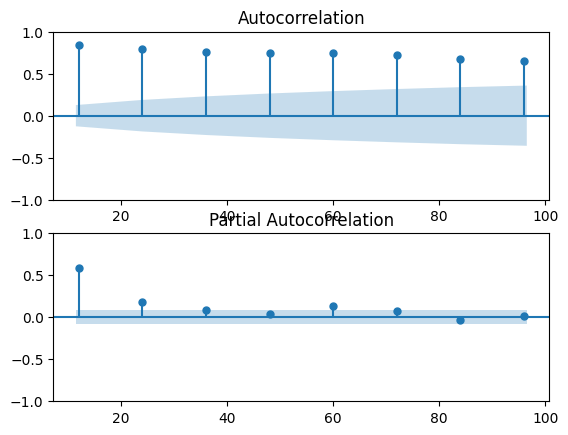

In [64]:
# Mevsimsel Parametreyi bulmak için
fig,(ax1,ax2) = plt.subplots(2,1)
plot_acf(candy_diff,lags=[i for i in range(12,100,12)],zero=False,ax=ax1)
plot_pacf(candy_diff,lags=[i for i in range(12,100,12)],zero=False,ax=ax2)
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# parametreler
S = 12
D = 1
d = 1 
P = 4
Q = 3
p = 4
q = 3

model = SARIMAX(candy,order=[p,d,q],seasonal_order=(P,D,Q,S))
results = model.fit()

In [ ]:
# %pip install pmdarima

 ARIMA(2,1,3)(0,0,0)[0]          
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  564
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1860.785
Date:                Mon, 11 Dec 2023   AIC                           3733.570
Time:                        12:34:47   BIC                           3759.570
Sample:                    01-01-1972   HQIC                          3743.720
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7056      0.011    160.814      0.000       1.685       1.726
ar.L2         -0.9692      0.012    -83.805      0.000      -0.992      -0.947
ma.L1         -1.9

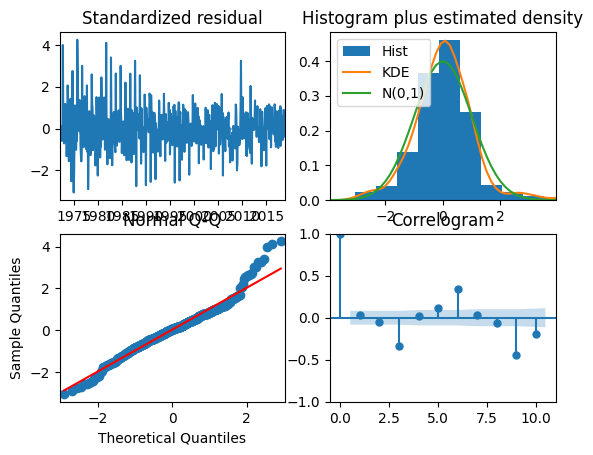

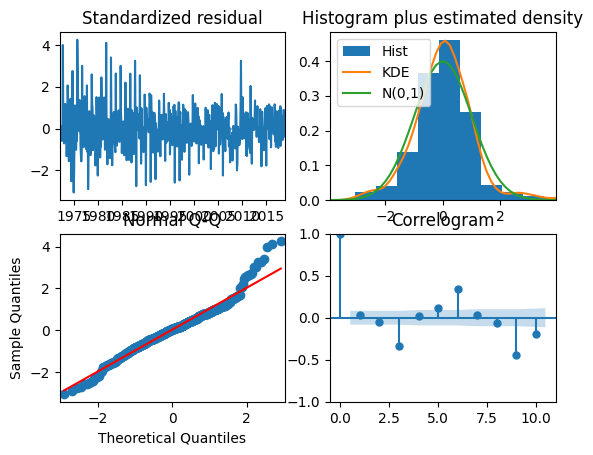

In [68]:
# model sıraları üzerinde arama 
import pmdarima as pm
sonuclar = pm.auto_arima(candy)
print(sonuclar)
print(sonuclar.summary())
sonuclar.plot_diagnostics()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=3033.673, Time=43.82 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3660.455, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3135.647, Time=5.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3329.958, Time=8.41 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3666.283, Time=0.06 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=3040.097, Time=25.54 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=3106.790, Time=25.89 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=3035.064, Time=262.51 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=3035.337, Time=342.64 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=3033.345, Time=130.82 sec
 ARIMA(2,0,2)(0,1,3)[12] intercept   : AIC=3035.330, Time=184.59 sec
 ARIMA(2,0,2)(1,1,3)[12] intercept   : AIC=3037.309, Time=102.17 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=3034.631, Time=34.59 sec
 ARIMA(2,0

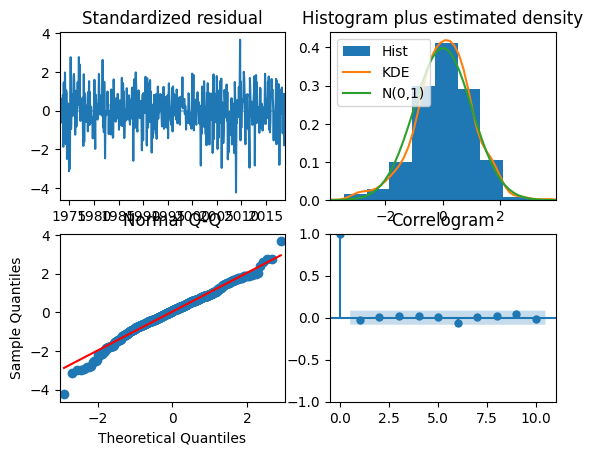

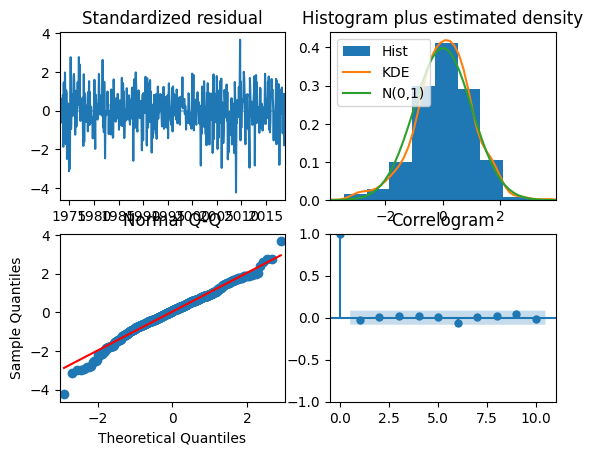

In [70]:
# Mevsimsel arama parametreleri 

sonuclar = pm.auto_arima(candy,# veri
seasonal=True, # zaman serisi mevsimsel mi
m=12, # mevsimsel dönem
D=1, # mevsimsel fark sırası
start_P=1, # P için başlangıç tahmini
start_Q=1, # Q için başlangıç tahmini
max_P=4, # denenecek maksimum P değeri
max_Q=4, # denenecek maksimum Q değeri
information_criterion='aic', # en iyi modeli seçmek için kullanılacak
trace=True, # eğitim sürecinde sonuçları yazdır
error_action='ignore', # çalışmayan sırayı yoksay,
stepwise=True # adım adım ilerlenecek => başlangıçtan dışa doğru
)
print(sonuclar)
print(sonuclar.summary())
sonuclar.plot_diagnostics()


In [71]:
# modeli kaydedelim 
import joblib
yol = 'model.pkl'
joblib.dump(sonuclar,yol)

yol = 'model.pkl'
yuklenen_model = joblib.load(yol)